### **Installing pyspark**

In [1]:
%pip install pyspark

Note: you may need to restart the kernel to use updated packages.


### **starting a spark session**

In [2]:
from pyspark.sql import SparkSession, functions
import sys

In [3]:
spark = SparkSession.builder.appName("ccbd-project").master("local").getOrCreate()

24/04/24 12:31:08 WARN Utils: Your hostname, Chirags-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.30.201.8 instead (on interface en0)
24/04/24 12:31:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/24 12:31:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark

### **Spark UI and to check if spark is running..**

In [5]:
df = spark.read.csv("./final_animedataset.csv",header = True,inferSchema = True)

24/04/24 12:31:21 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


* ### inferSchema gives the actual dtype of the columns or then it will be just 'string'
* ### header = True maps the actual column names instead or _c0,_c1

In [6]:
df.printSchema() #like df.info()
#df.dtypes also helps

root
 |-- username: string (nullable = true)
 |-- anime_id: integer (nullable = true)
 |-- my_score: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- title: string (nullable = true)
 |-- type: string (nullable = true)
 |-- source: string (nullable = true)
 |-- score: string (nullable = true)
 |-- scored_by: double (nullable = true)
 |-- rank: double (nullable = true)
 |-- popularity: double (nullable = true)
 |-- genre: string (nullable = true)



In [7]:
df.columns

['username',
 'anime_id',
 'my_score',
 'user_id',
 'gender',
 'title',
 'type',
 'source',
 'score',
 'scored_by',
 'rank',
 'popularity',
 'genre']

In [8]:
df.show()

+--------+--------+--------+-------+------+--------------------+----+------------+-----+---------+------+----------+--------------------+
|username|anime_id|my_score|user_id|gender|               title|type|      source|score|scored_by|  rank|popularity|               genre|
+--------+--------+--------+-------+------+--------------------+----+------------+-----+---------+------+----------+--------------------+
|karthiga|      21|       9|2255153|Female|           One Piece|  TV|       Manga| 8.54| 423868.0|  91.0|      35.0|Action, Adventure...|
|karthiga|      59|       7|2255153|Female|             Chobits|  TV|       Manga| 7.53| 175388.0|1546.0|     188.0|Sci-Fi, Comedy, D...|
|karthiga|      74|       7|2255153|Female|        Gakuen Alice|  TV|       Manga| 7.77|  33244.0| 941.0|    1291.0|Comedy, School, S...|
|karthiga|     120|       7|2255153|Female|       Fruits Basket|  TV|       Manga| 7.77| 167968.0| 939.0|     222.0|Slice of Life, Co...|
|karthiga|     178|       7|225515

### From analysing the dataset,
#### * username is mapped to an user_id
#### * title is mapped to an anime_id
#### * for 1 user, the fields - username, user_id, gender is same for all the ratings of the user
#### * for 1 anime, the fields - anime_id, title, type, source, score, scored_by, rank, popularity and genre is same for all the ratings of that particular anime
#### * genre is a string consiting of multiple strings separated by comma

In [9]:
df.select(['username','user_id','gender']).show()

+--------+-------+------+
|username|user_id|gender|
+--------+-------+------+
|karthiga|2255153|Female|
|karthiga|2255153|Female|
|karthiga|2255153|Female|
|karthiga|2255153|Female|
|karthiga|2255153|Female|
|karthiga|2255153|Female|
|karthiga|2255153|Female|
|karthiga|2255153|Female|
|karthiga|2255153|Female|
|karthiga|2255153|Female|
|karthiga|2255153|Female|
|karthiga|2255153|Female|
|karthiga|2255153|Female|
|karthiga|2255153|Female|
|karthiga|2255153|Female|
|karthiga|2255153|Female|
|karthiga|2255153|Female|
|karthiga|2255153|Female|
|karthiga|2255153|Female|
|karthiga|2255153|Female|
+--------+-------+------+
only showing top 20 rows



In [10]:
df.select(['anime_id','title','type','source','score','scored_by','rank','popularity','genre']).show(54)

+--------+--------------------+----+------------+-----+---------+------+----------+--------------------+
|anime_id|               title|type|      source|score|scored_by|  rank|popularity|               genre|
+--------+--------------------+----+------------+-----+---------+------+----------+--------------------+
|      21|           One Piece|  TV|       Manga| 8.54| 423868.0|  91.0|      35.0|Action, Adventure...|
|      59|             Chobits|  TV|       Manga| 7.53| 175388.0|1546.0|     188.0|Sci-Fi, Comedy, D...|
|      74|        Gakuen Alice|  TV|       Manga| 7.77|  33244.0| 941.0|    1291.0|Comedy, School, S...|
|     120|       Fruits Basket|  TV|       Manga| 7.77| 167968.0| 939.0|     222.0|Slice of Life, Co...|
|     178|        Ultra Maniac|  TV|       Manga| 7.26|   9663.0|2594.0|    2490.0|Magic, Comedy, Ro...|
|     210|             Ranma ½|  TV|       Manga| 7.85|  59911.0| 802.0|     623.0|Slice of Life, Co...|
|     232|   Cardcaptor Sakura|  TV|       Manga| 8.21|

#### By comparing 1st and last row - One Piece, we can confirm our above hypothesis


#### Now, we can check if any missing values exist in any of the columns 

In [11]:
from pyspark.sql.functions import *
missing = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing.show()

+--------+--------+--------+-------+------+-----+----+------+-----+---------+------+----------+-----+
|username|anime_id|my_score|user_id|gender|title|type|source|score|scored_by|  rank|popularity|genre|
+--------+--------+--------+-------+------+-----+----+------+-----+---------+------+----------+-----+
|     256|       0|       0|      0|     0|    0|   0|     0|    0|        0|751600|       370| 2267|
+--------+--------+--------+-------+------+-----+----+------+-----+---------+------+----------+-----+



In [12]:
df.filter(col("genre").isNull()).show(100)

+----------------+--------+--------+-------+----------+--------------------+-------+-----------+-----+---------+------+----------+-----+
|        username|anime_id|my_score|user_id|    gender|               title|   type|     source|score|scored_by|  rank|popularity|genre|
+----------------+--------+--------+-------+----------+--------------------+-------+-----------+-----+---------+------+----------+-----+
|   MistButterfly|   17813|       5|2485327|    Female|Kyoto Animation: ...|Special|Light novel| 6.42|   3617.0|5925.0|    4162.0| NULL|
|    Aria-da-Capo|   17813|       0|3935001|      Male|Kyoto Animation: ...|Special|Light novel| 6.42|   3617.0|5925.0|    4162.0| NULL|
|    Aria-da-Capo|   28647|       0|3935001|      Male|               Kappo|  Movie|    Unknown| 4.45|    264.0|9376.0|    9714.0| NULL|
|    Aria-da-Capo|   29629|       0|3935001|      Male|        Coffee Break|  Movie|    Unknown|  5.1|    250.0|8940.0|    9619.0| NULL|
|    Aria-da-Capo|   31832|       0|39350

In [13]:
df.count()

35305695

#### We can infer that missing values are from columns - username, rank, popularity and genre
##### Username - we drop the rows simply cause they would be invalid
##### rank - we cannot impute it, as it wouldn't make sense, but the rows will null values will ignore the rank into its evaluation, if possible
##### popularity - same as rank
##### genre - same as rank

In [14]:
df = df.na.drop()

In [15]:
df.filter(col("username").isNull()).show()

+--------+--------+--------+-------+------+-----+----+------+-----+---------+----+----------+-----+
|username|anime_id|my_score|user_id|gender|title|type|source|score|scored_by|rank|popularity|genre|
+--------+--------+--------+-------+------+-----+----+------+-----+---------+----+----------+-----+
+--------+--------+--------+-------+------+-----+----+------+-----+---------+----+----------+-----+



#### Let's head over to EDA
##### 1.Analyze the dataset to find the popular animes according to users


In [16]:
df.select('title').distinct().count()

7633

In [17]:
df.select('user_id').distinct().count()

116046

##### There are 8746 animes and 116124 users
##### Popular animes according to users means we take considerations of how many users rated and maybe popularity also

In [18]:
df.groupBy("title").agg({"my_score":"sum"}).orderBy((desc("sum(my_score)"))).show()

+--------------------+-------------+
|               title|sum(my_score)|
+--------------------+-------------+
|          Death Note|       631638|
|Code Geass: Hangy...|       486454|
|  Shingeki no Kyojin|       467593|
|Fullmetal Alchemi...|       459099|
|        Angel Beats!|       430046|
|Code Geass: Hangy...|       428001|
|           Toradora!|       426568|
|Sen to Chihiro no...|       420634|
|              Naruto|       420020|
|    Sword Art Online|       419929|
|          Elfen Lied|       415597|
| Fullmetal Alchemist|       400600|
|         Steins;Gate|       380473|
|              Bleach|       378783|
|             Clannad|       378314|
|Tengen Toppa Gurr...|       357798|
|Suzumiya Haruhi n...|       350842|
|          Durarara!!|       334275|
|Clannad: After Story|       332519|
|          Soul Eater|       329587|
+--------------------+-------------+
only showing top 20 rows



In [19]:
df.groupBy("title").agg({"popularity": "sum"}).orderBy((desc("sum(popularity)"))).show()

+--------------------+---------------+
|               title|sum(popularity)|
+--------------------+---------------+
|"Gyakuten Saiban:...|     4.548581E7|
|Fullmetal Alchemi...|    1.6506444E7|
|Kore ga Watashi n...|    1.6450852E7|
|Final Fantasy: Th...|    1.6381365E7|
|Final Fantasy VII...|    1.6259616E7|
|       Ookamikakushi|     1.609898E7|
|Full Metal Panic!...|     1.594485E7|
|Love Hina Christm...|    1.5814434E7|
|Naruto: Takigakur...|     1.578144E7|
|       Genshiken OVA|    1.5761826E7|
|Love Hina Haru Sp...|    1.5760773E7|
|Higurashi no Naku...|      1.57472E7|
|                Sola|     1.569568E7|
|Hanbun no Tsuki g...|      1.56882E7|
|   Hatsukoi Limited.|    1.5574383E7|
|                 Rec|    1.5496704E7|
|    Chobits: Chibits|    1.5448738E7|
|Dogs: Bullets & C...|     1.544543E7|
|         Genshiken 2|    1.5414845E7|
|             Kannagi|    1.5396024E7|
+--------------------+---------------+
only showing top 20 rows



##### These are the top 20, if you want more(x) you can put .show(x)

##### 2.Find the most popular anime for every genre

In [66]:
genres = df.withColumn("genre", explode(split(col("genre"), ",")))

num = genres.select("genre").distinct().count()

total_genres = genres.select("genre").distinct().rdd.flatMap(lambda x: x).collect()

print("Number of genres:", num)
print("List of genres:", total_genres)

Number of genres: 78
List of genres: ['Seinen', ' Harem', ' Sports', ' Shounen Ai', ' Ecchi', ' Military', 'Dementia', 'Romance', 'Magic', ' Historical', 'Thriller', ' Psychological', 'Josei', ' Romance', ' Demons', 'Adventure', 'Super Power', 'Martial Arts', 'Sports', 'Shoujo', 'Drama', 'School', 'Military', 'Samurai', ' Comedy', ' Shounen', ' Police', ' Drama', ' Thriller', 'Fantasy', ' Parody', 'Demons', ' Super Power', ' Shoujo Ai', 'Police', 'Vampire', ' Game', 'Mecha', 'Mystery', 'Supernatural', ' Mystery', ' Kids', ' Dementia', '1080', ' Samurai', 'Music', ' Mecha', 'Shounen', 'Slice of Life', ' Cars', 'Game', 'Ecchi', 'Kids', ' School', ' Supernatural', ' Sci-Fi', ' Shoujo', ' Vampire', 'Space', 'Cars', 'Harem', 'Psychological', 'Horror', ' Josei', ' Martial Arts', ' Magic', ' Adventure', ' Fantasy', ' Horror', ' Space', 'Comedy', ' Seinen', 'Action', 'Historical', ' Music', ' Slice of Life', 'Parody', 'Sci-Fi']


##### There are 84 genres out of which 2 we felt aren't valid, 1080 and 6455
##### Therefore, we decided to remove them from our analysis

##### Popular - popularity column for each genre


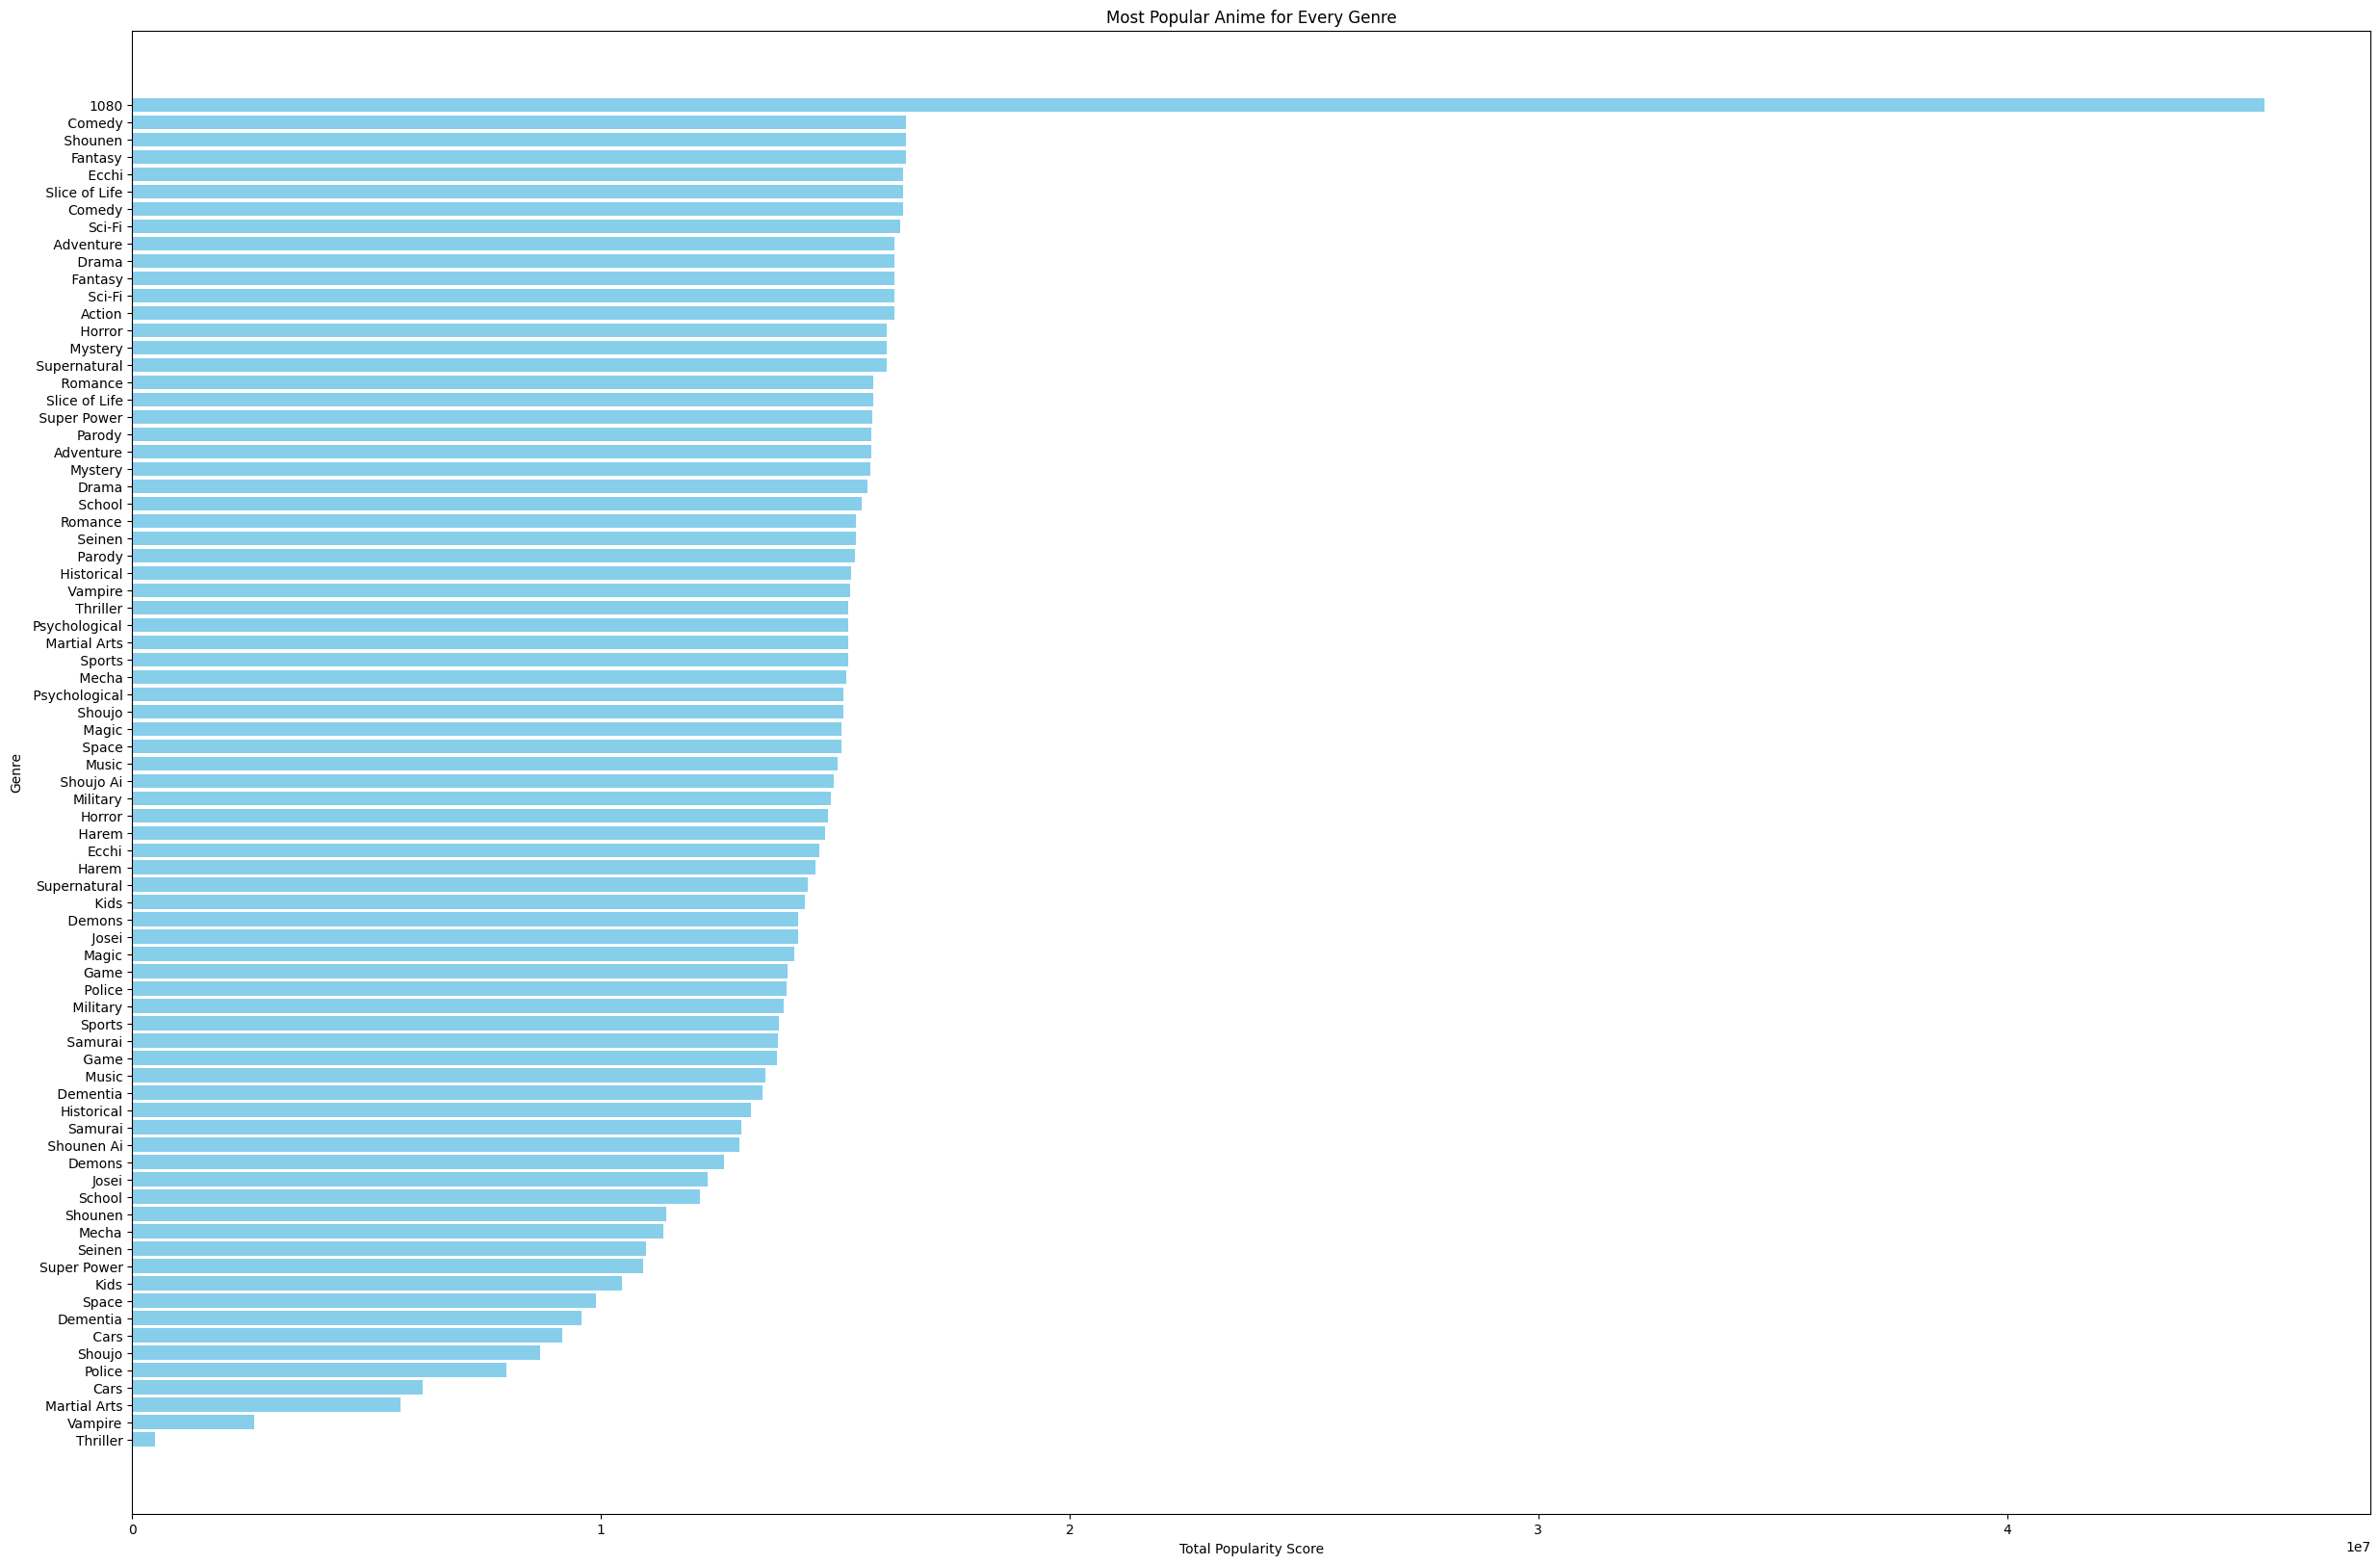

In [71]:
from pyspark.sql.window import *
import matplotlib.pyplot as plt
genre_popularity = genres.groupBy("genre", "title").agg(sum("popularity").alias("total_popularity"))

window = Window.partitionBy("genre").orderBy(col("total_popularity").desc())
ranked_genre_popularity = genre_popularity.withColumn("rank", rank().over(window))

most_popular_anime_by_genre = ranked_genre_popularity.filter(col("rank") == 1)

genre_popularity_pd = most_popular_anime_by_genre.orderBy(col("total_popularity").desc()).toPandas()


plt.figure(figsize=(30,20))
plt.barh(genre_popularity_pd["genre"], genre_popularity_pd["total_popularity"], color='skyblue')
plt.xlabel('Total Popularity Score')
plt.ylabel('Genre')
plt.title('Most Popular Anime for Every Genre')
plt.gca().invert_yaxis()  
plt.show()

##### 3.Find the most popular anime genre for every gender

In [23]:
from pyspark.sql.window import Window

genre_popularity = df.groupBy("gender", "genre").agg(sum("popularity").alias("popularity"))
window = Window.partitionBy("gender").orderBy(col("popularity").desc())

genre_popularity = genre_popularity.withColumn("rank", rank().over(window))

most_popular_genre = genre_popularity.filter(col("rank") == 1).select("gender", "genre")

most_popular_genre.show()



+----------+------+
|    gender| genre|
+----------+------+
|    Female|Comedy|
|      Male|Comedy|
|Non-Binary| Music|
+----------+------+



##### 4.Are there any power users (users with a high number of ratings) in the dataset?

In [72]:
user_ratings_count = df.groupBy("user_id").agg(count("anime_id").alias("number_of_ratings"))

percentile_threshold = 0.9
quantile_value = user_ratings_count.approxQuantile("number_of_ratings", [percentile_threshold], 0.05)

threshold = quantile_value[0] if quantile_value else 0

power_users = user_ratings_count.filter(col("number_of_ratings") >= threshold)
power_users.show(truncate=False)



+-------+-----------------+
|user_id|number_of_ratings|
+-------+-----------------+
|3175   |641              |
|3976645|865              |
|40574  |592              |
|5796856|597              |
|22970  |2496             |
|3463575|690              |
|75949  |823              |
|188603 |632              |
|120422 |1170             |
|350614 |1502             |
|8779   |647              |
|4905334|621              |
|128889 |2124             |
|488871 |794              |
|65288  |749              |
|6907514|664              |
|1665963|1056             |
|568087 |642              |
|1487133|640              |
|157398 |716              |
+-------+-----------------+
only showing top 20 rows



##### 5.Which anime titles have the highest number of user ratings?

In [ ]:
df.groupBy("title").agg({"scored_by": "sum"}).orderBy((desc("sum(scored_by)"))).show()

+--------------------+---------------+
|               title| sum(scored_by)|
+--------------------+---------------+
|          Death Note|8.6453629234E10|
|  Shingeki no Kyojin|6.1885628231E10|
|    Sword Art Online|6.0310350212E10|
|Fullmetal Alchemi...|4.9247498144E10|
|Code Geass: Hangy...| 4.482942436E10|
|              Naruto|4.3030401515E10|
|        Angel Beats!|4.1914795853E10|
|           Toradora!|3.7222396662E10|
|          Elfen Lied|  3.50352072E10|
|         Steins;Gate|3.3852846566E10|
|    Mirai Nikki (TV)| 3.380658794E10|
|Code Geass: Hangy...|3.1902145216E10|
|       One Punch Man|3.1838015055E10|
|         Tokyo Ghoul|3.1305262456E10|
| Fullmetal Alchemist|3.0094011123E10|
|     No Game No Life|3.0021467817E10|
|Sen to Chihiro no...|2.8693049294E10|
|      Ao no Exorcist|2.7674305668E10|
|              Bleach|2.7658007517E10|
|Highschool of the...|2.6743186808E10|
+--------------------+---------------+
only showing top 20 rows



##### 6.Is there a relationship between an anime's source (e.g., manga, light novel, original) and its rating or popularity?

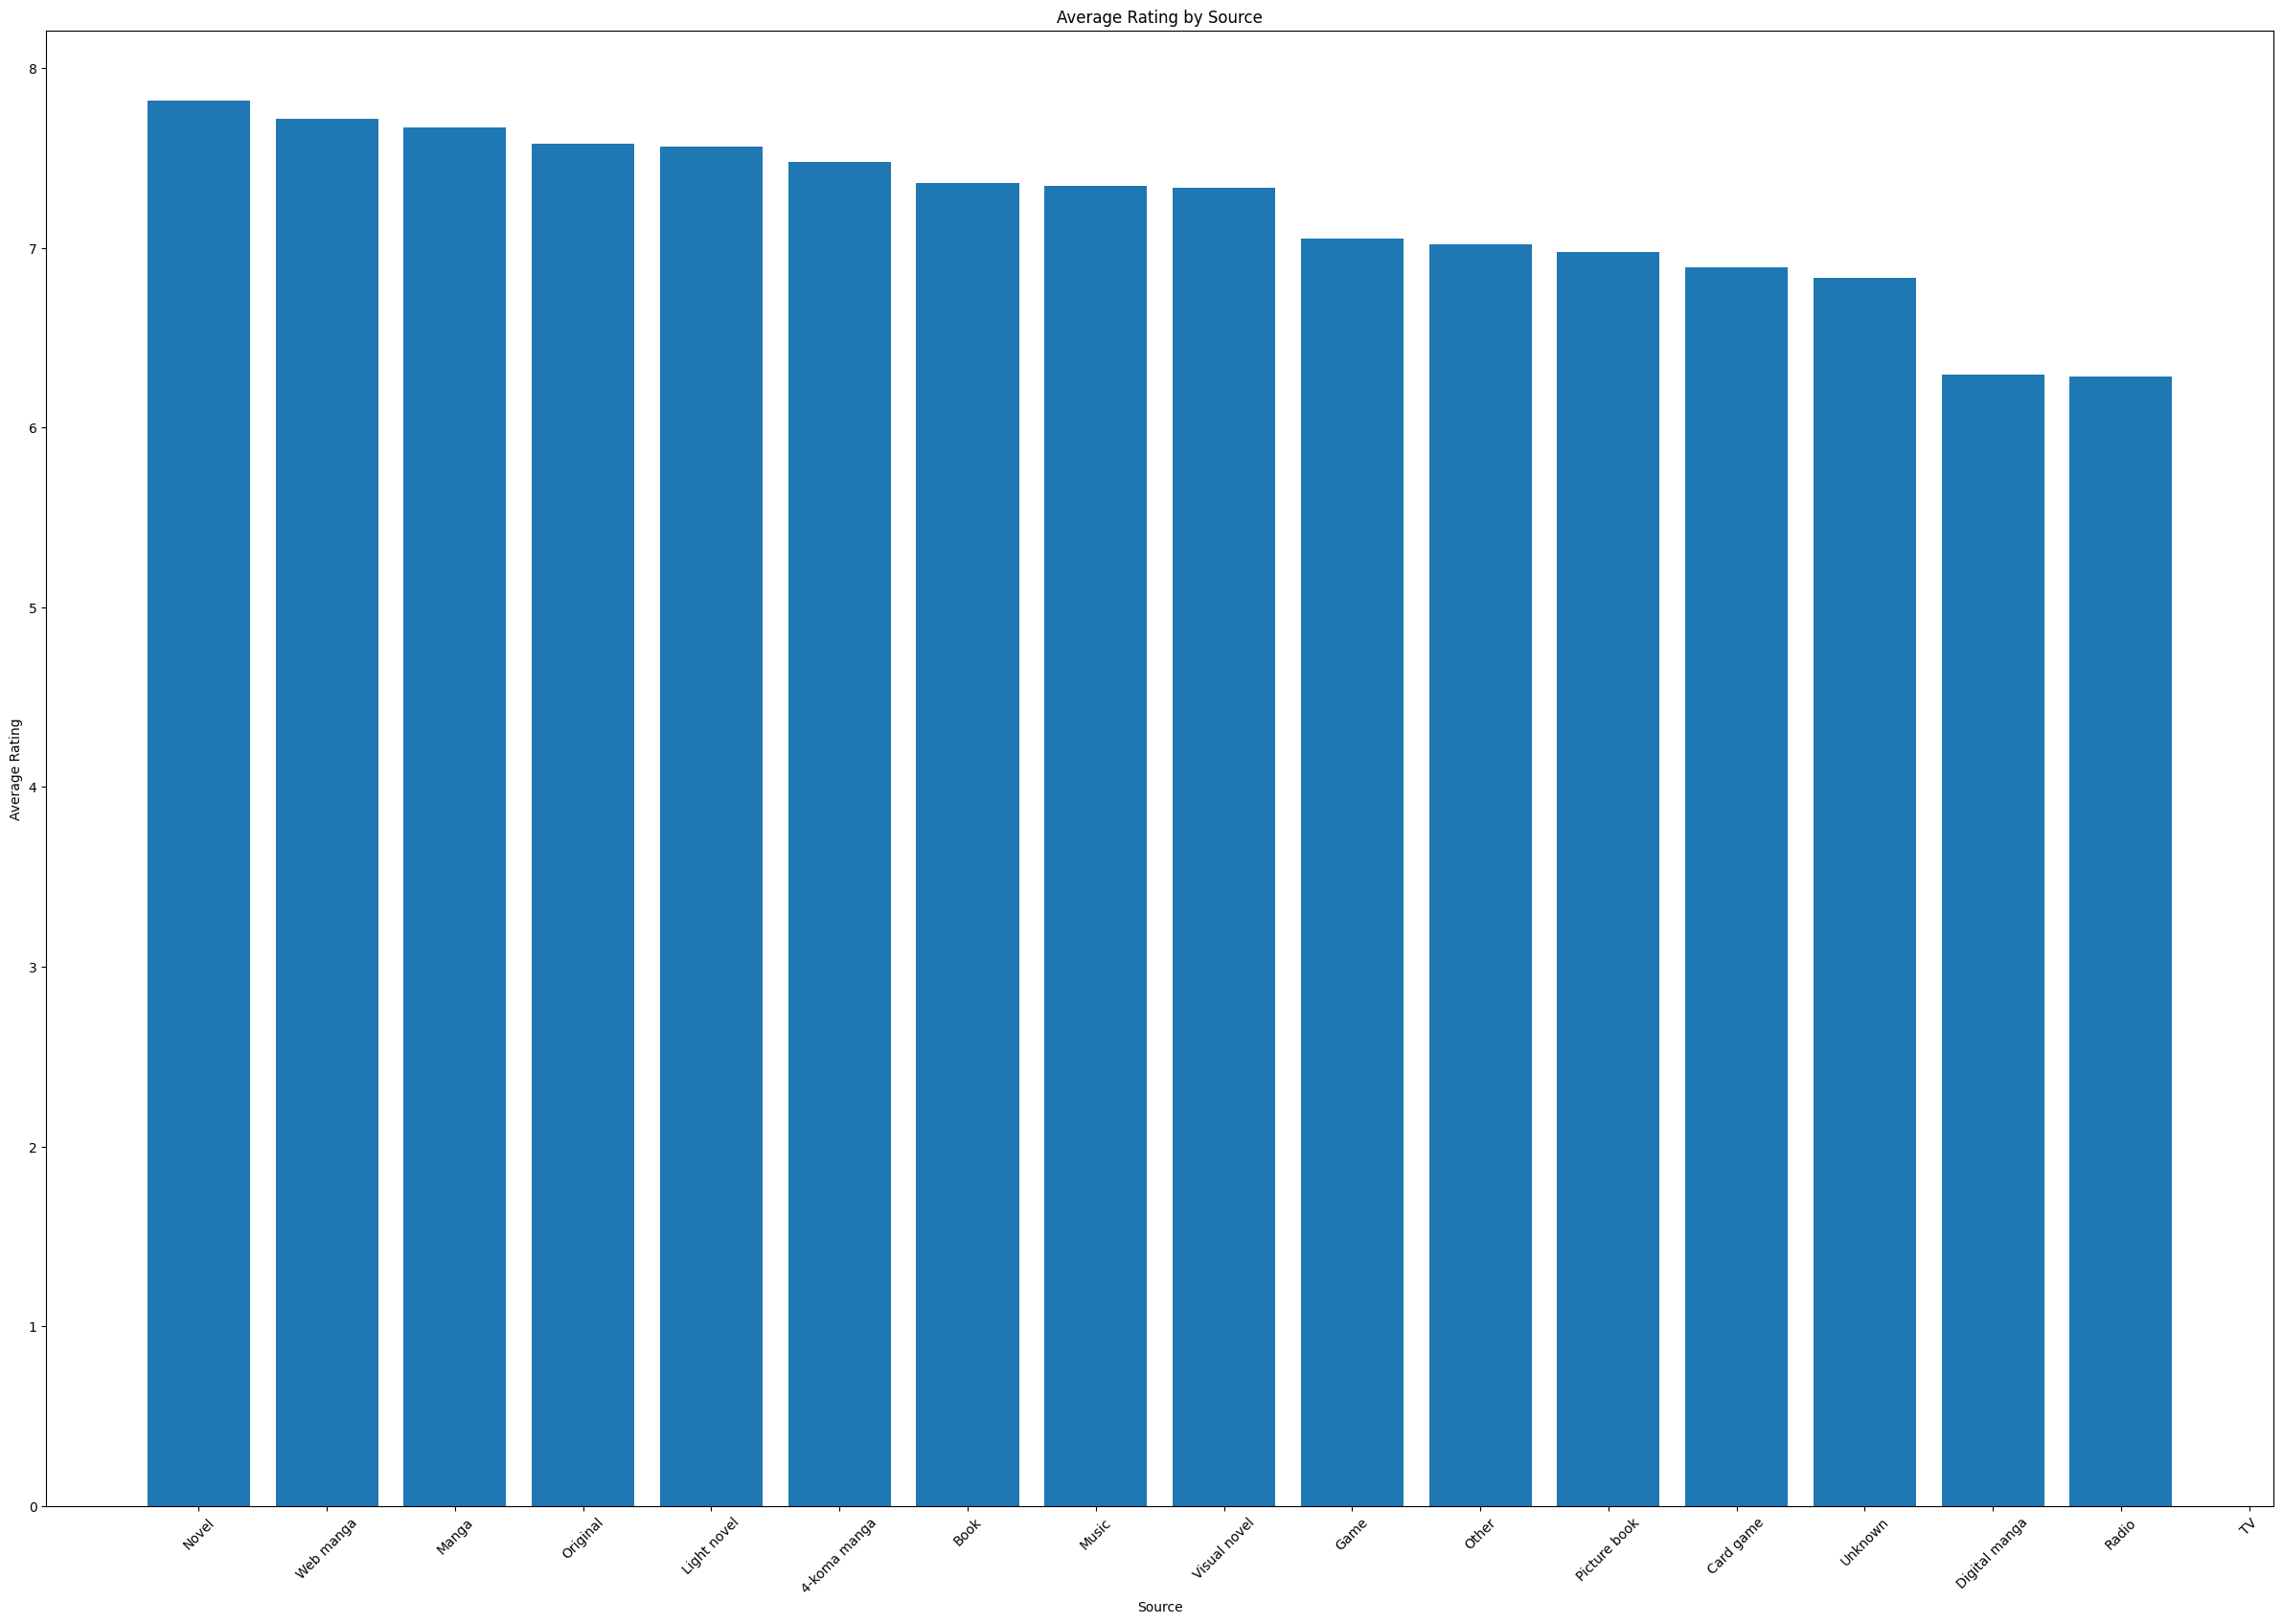

In [ ]:
ratings_by_source = df.groupBy("source").agg({"score": "mean"}).orderBy(desc("avg(score)")).toPandas()
plt.figure(figsize=(30,20))
plt.bar(ratings_by_source["source"], ratings_by_source["avg(score)"])
plt.xlabel("Source")
plt.ylabel("Average Rating")
plt.title("Average Rating by Source")
plt.xticks(rotation=45)
plt.show()

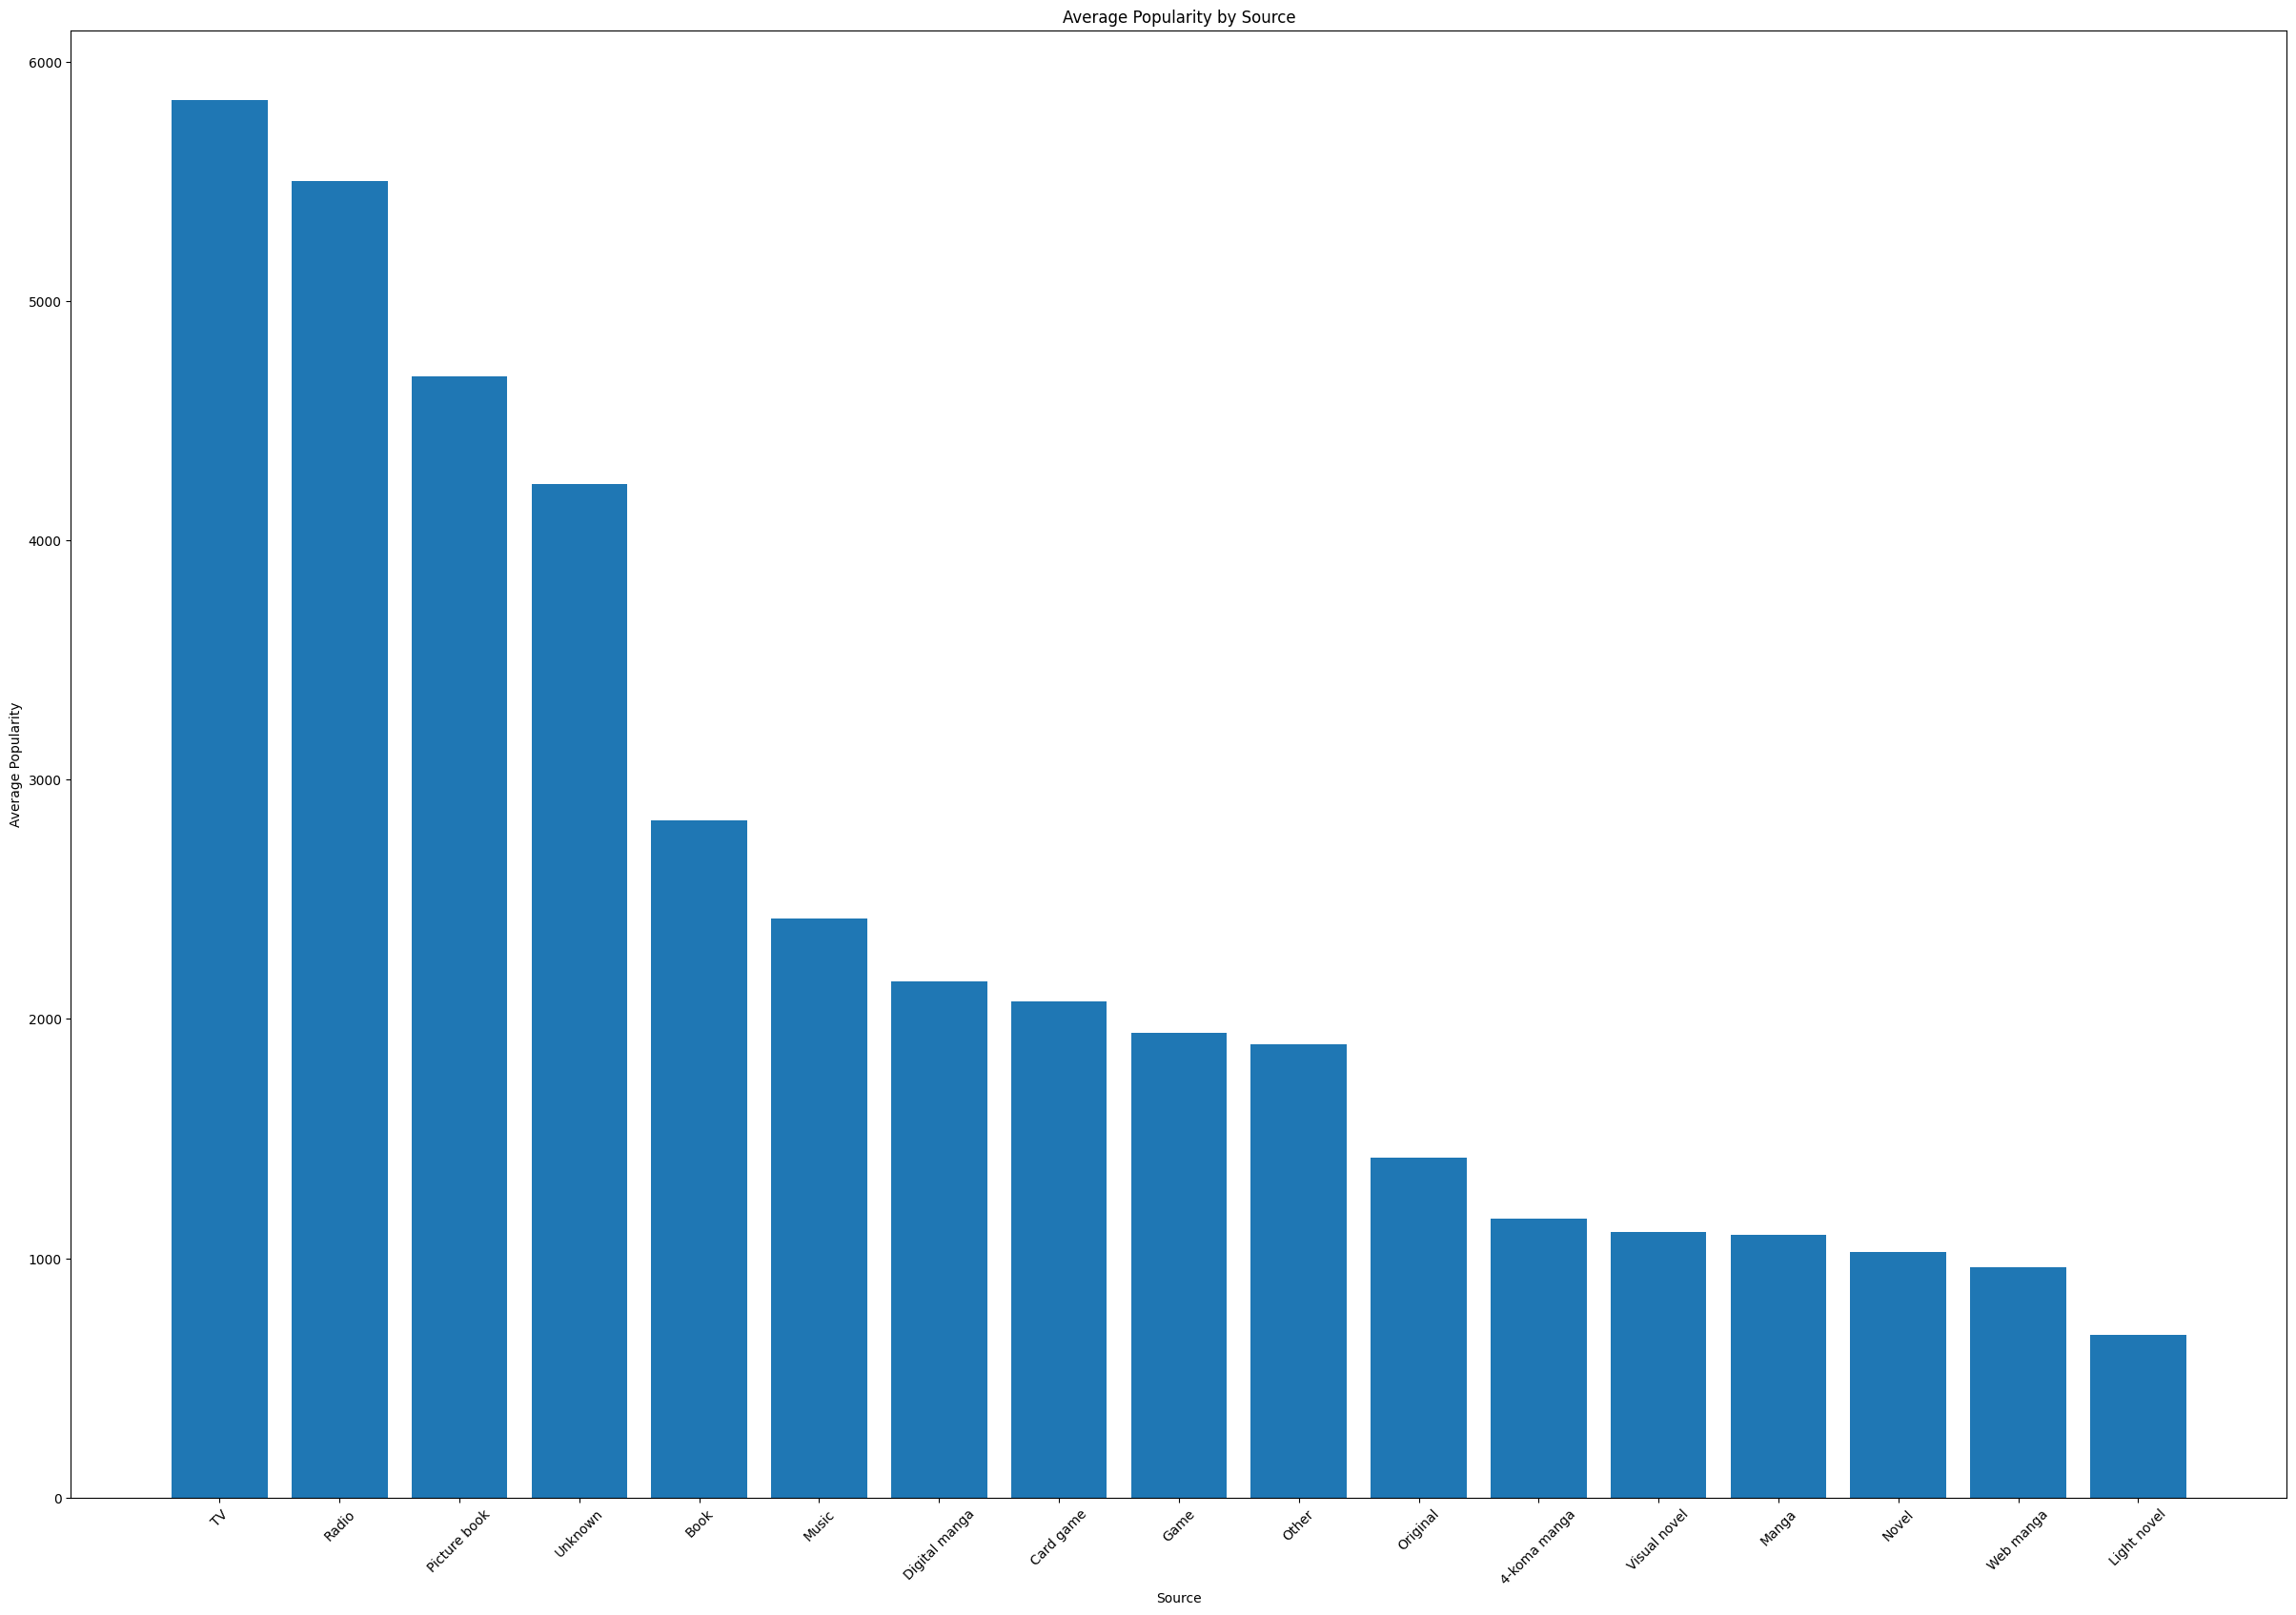

In [ ]:
popularity_by_source = df.groupBy("source").agg({"popularity": "mean"}).orderBy(desc("avg(popularity)")).toPandas()
plt.figure(figsize=(30,20))
plt.bar(popularity_by_source["source"], popularity_by_source["avg(popularity)"])
plt.xlabel("Source")
plt.ylabel("Average Popularity")
plt.title("Average Popularity by Source")
plt.xticks(rotation=45)
plt.show()

In [48]:
df_model = df.select(['user_id', 'anime_id', 'my_score'])

In [ ]:
df_model.show()

+-------+--------+--------+
|user_id|anime_id|my_score|
+-------+--------+--------+
|2255153|      21|       9|
|2255153|      59|       7|
|2255153|      74|       7|
|2255153|     120|       7|
|2255153|     178|       7|
|2255153|     210|       7|
|2255153|     232|       6|
|2255153|     233|       6|
|2255153|     249|       8|
|2255153|     269|      10|
|2255153|     721|       7|
|2255153|     853|       7|
|2255153|     857|      10|
|2255153|     957|       8|
|2255153|     966|      10|
|2255153|    1557|       8|
|2255153|    1571|       8|
|2255153|    1579|       9|
|2255153|    1698|       7|
|2255153|    1735|       9|
+-------+--------+--------+
only showing top 20 rows



In [25]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

In [73]:
df.show()

+--------+--------+--------+-------+------+--------------------+----+------------+-----+---------+------+----------+--------------------+
|username|anime_id|my_score|user_id|gender|               title|type|      source|score|scored_by|  rank|popularity|               genre|
+--------+--------+--------+-------+------+--------------------+----+------------+-----+---------+------+----------+--------------------+
|karthiga|      21|       9|2255153|Female|           One Piece|  TV|       Manga| 8.54| 423868.0|  91.0|      35.0|Action, Adventure...|
|karthiga|      59|       7|2255153|Female|             Chobits|  TV|       Manga| 7.53| 175388.0|1546.0|     188.0|Sci-Fi, Comedy, D...|
|karthiga|      74|       7|2255153|Female|        Gakuen Alice|  TV|       Manga| 7.77|  33244.0| 941.0|    1291.0|Comedy, School, S...|
|karthiga|     120|       7|2255153|Female|       Fruits Basket|  TV|       Manga| 7.77| 167968.0| 939.0|     222.0|Slice of Life, Co...|
|karthiga|     178|       7|225515

In [26]:
(training, test) = df.randomSplit([.8, .2])

In [75]:
als = ALS(maxIter=10, rank=50, regParam=0.01, userCol='user_id', itemCol='anime_id', ratingCol='my_score', coldStartStrategy='drop')

In [32]:
model = als.fit(training)

In [35]:
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName='rmse', labelCol='my_score', predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print(rmse)

3.039362121215678


In [42]:
df_titles = df.select(["username","title"])
df_titles.show()

+--------+--------------------+
|username|               title|
+--------+--------------------+
|karthiga|           One Piece|
|karthiga|             Chobits|
|karthiga|        Gakuen Alice|
|karthiga|       Fruits Basket|
|karthiga|        Ultra Maniac|
|karthiga|             Ranma ½|
|karthiga|   Cardcaptor Sakura|
|karthiga|      Daa! Daa! Daa!|
|karthiga|            InuYasha|
|karthiga|              Bleach|
|karthiga|       Princess Tutu|
|karthiga|Ouran Koukou Host...|
|karthiga|            Air Gear|
|karthiga|Saiunkoku Monogatari|
|karthiga|    Crayon Shin-chan|
|karthiga|    Shounen Onmyouji|
|karthiga|          Ghost Hunt|
|karthiga|Kiniro no Corda: ...|
|karthiga|    Nodame Cantabile|
|karthiga|  Naruto: Shippuuden|
+--------+--------------------+
only showing top 20 rows



In [45]:
userRecommends = model.recommendForAllUsers(5)
userRecommends.show(10, False)

+-------+----------------------------------------------------------------------------------------------------+
|user_id|recommendations                                                                                     |
+-------+----------------------------------------------------------------------------------------------------+
|1      |[{20945, 15.780325}, {32233, 15.076314}, {2487, 14.811648}, {6390, 14.50965}, {30751, 14.200542}]   |
|3      |[{36920, 13.1030035}, {35626, 12.898226}, {3462, 11.918374}, {30751, 11.795857}, {35552, 11.641739}]|
|4      |[{9789, 13.367682}, {7664, 12.423806}, {32461, 12.114177}, {33689, 11.783273}, {10534, 11.106619}]  |
|20     |[{19235, 22.974983}, {20929, 22.627151}, {17068, 21.075108}, {30907, 20.384409}, {7504, 19.440405}] |
|37     |[{37150, 37.09483}, {9013, 32.104206}, {15347, 28.087515}, {4688, 24.21323}, {31608, 23.52693}]     |
|47     |[{33911, 24.103477}, {35552, 21.451506}, {3059, 16.292809}, {36232, 16.153128}, {32349, 15.934778}] |
|

In [37]:
for_one_user = predictions.filter(col("user_id") == 2485327)

In [38]:
for_one_user.show()

+-------------+--------+--------+-------+------+--------------------+-------+-----------+-----+---------+------+----------+--------------------+----------+
|     username|anime_id|my_score|user_id|gender|               title|   type|     source|score|scored_by|  rank|popularity|               genre|prediction|
+-------------+--------+--------+-------+------+--------------------+-------+-----------+-----+---------+------+----------+--------------------+----------+
|MistButterfly|    1238|       5|2485327|Female|One Piece: Mamore...|Special|      Manga| 7.46|   9344.0|1782.0|    2728.0|Adventure, Comedy...|  4.748078|
|MistButterfly|    1829|       5|2485327|Female|          Gedo Senki|  Movie|      Novel| 7.13|  44087.0|3072.0|    1125.0|Adventure, Fantas...| 6.4485617|
|MistButterfly|    6336|       7|2485327|Female|Mobile Suit Gunda...|    OVA|      Novel| 8.31|  23492.0| 232.0|    1481.0|Action, Drama, Me...|  4.788946|
|MistButterfly|   11033|       3|2485327|Female|Natsu-iro Egao d

In [41]:
df.describe().show()

24/04/24 13:12:25 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------------+------------------+------------------+------------------+----------+------------------+----------+------------+------------------+------------------+------------------+-----------------+--------+
|summary|     username|          anime_id|          my_score|           user_id|    gender|             title|      type|      source|             score|         scored_by|              rank|       popularity|   genre|
+-------+-------------+------------------+------------------+------------------+----------+------------------+----------+------------+------------------+------------------+------------------+-----------------+--------+
|  count|     34551202|          34551202|          34551202|          34551202|  34551202|          34551202|  34551202|    34551202|          34551202|          34551202|          34551202|         34551202|34551202|
|   mean|     Infinity| 11533.37975984164| 4.610090699594185| 1867659.264544921|      NULL|243050.69646882045|      NULL|   